# Benchmark different QBMs

This notebook goes through the steps that we implemented in the `scripts/benchmark.py` file.

## Define the parameters of the model: QBM

Here we select the number of qubits of the Gibbs state, the model Hamiltonian to use in the definition of the QBM, the depolarizing noise strength to compute expectation values and the training hyperparameters.

In [1]:
"""
Benchmark a QBM on the Hamiltonian dataset
"""
import numpy as np

##########
# CONFIG #
##########

rng = np.random.default_rng(seed=1)

n_qubits = 4
model_label = 0 # 0: 1D TFIM 1: 1D Heisenberg
depolarizing_noise = 0.0 # if noisy expectation values
learning_rate = 0.2
epochs = 1000
eps = 1e-6
compute_qre = True



The model Hamiltonian is defined as a list of operators $H = \sum_{i=0}^m \theta_i H_i $

In [2]:
from qbm_quimb import hamiltonians
# A list of operators in the model Hamiltonian
model_ham_ops = hamiltonians.hamiltonian_operators(n_qubits, model_label)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
model_ham_ops[0].shape  # 2^n_qubits x 2^n_qubits

(16, 16)

## Define the data

Here we work with _quantum_ data in the form of the Gibbs state of a target Hamiltonian at a fixed inverse temperature $\beta$.


In [4]:
from qbm_quimb import data

########
# DATA #
########

# As an example, the Gibbs state of TF-Ising model (label=0)
# is taken to generate data (expectation values)
target_label = 0
target_params = np.array([4.0, 4.0])
target_beta = 1.0

# generate expectation values: quantum data
target_expects, target_state = data.generate_data(
    n_qubits,
    target_label,
    target_params,
    target_beta,
    model_ham_ops,
    depolarizing_noise,
)


The expectation values of the model Hamiltonian operators are computed with respect to the target Gibbs state.

In [5]:
target_expects  # expectation values w.r.t. target density matrix

[-1.5704512469019736, -3.146996251579949]

## Start the training by minimizing the relative entropy

We initialize the parameters of the model QBM and then train with stochastic gradient descent (SGD)

In [6]:
from qbm_quimb.training import QBM, train_qbm


#############
# QBM Model #
#############

initial_params = rng.normal(size=len(model_ham_ops))
qbm_state = QBM(model_ham_ops, initial_params)
print(f"Initial parameters: {qbm_state.get_coeffs()}")
print(f"Target parameters: {target_params}")
print(f"Target beta: {target_beta}")




Initial parameters: [0.34558419 0.82161814]
Target parameters: [4. 4.]
Target beta: 1.0


In [7]:
################
# QBM Taininig #
################

target_eta = None
if compute_qre:
    target_eta = target_state

qbm_state, max_grads_hist, qre_hist = train_qbm(
    qbm=qbm_state,
    target_expects=target_expects,
    learning_rate=learning_rate,
    epochs=epochs,
    eps=eps,
    compute_qre=compute_qre,
    target_eta=target_eta,
)

print(f"Trained parameters: {qbm_state.get_coeffs()}")
print(f"Max. gradients: {max_grads_hist[-1]}")
if compute_qre:
    print(f"Initial relative entropy: {qre_hist[0]}")
    print(f"Trained relative entropy: {qre_hist[-1]}")


Trained parameters: [-3.86103966 -3.87574421]
Max. gradients: 0.0016439366283633738
Initial relative entropy: 7.096519673662146
Trained relative entropy: 0.00020229007839844826


## Plot training history

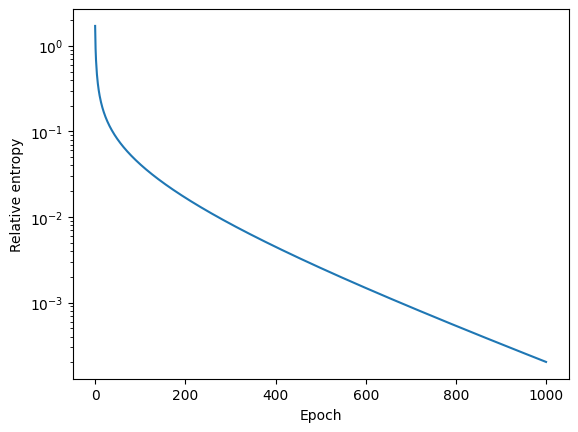

In [8]:
import matplotlib.pyplot as plt

if compute_qre:
    plt.plot(qre_hist[1:], "-")
    plt.xlabel("Epoch")
    plt.ylabel("Relative entropy")
    plt.yscale('log')
    plt.show()


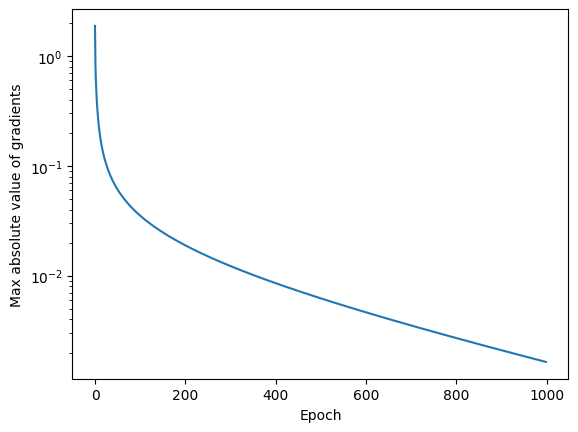

In [9]:
plt.plot(max_grads_hist[1:], "-")
plt.xlabel("Epoch")
plt.ylabel("Max absolute value of gradients")
plt.yscale('log')
plt.show()

## Check fidelity with the Gibbs state

In [10]:
target_eta

[[ 0.01114 +0.j -0.017062+0.j -0.026152+0.j  0.015006+0.j -0.026152+0.j  0.049133+0.j  0.023003+0.j -0.017067+0.j
  -0.017062+0.j  0.022979+0.j  0.049133+0.j -0.026136+0.j  0.015006+0.j -0.026136+0.j -0.017067+0.j  0.011136+0.j]
 [-0.017062+0.j  0.026908+0.j  0.038615+0.j -0.022727+0.j  0.041471+0.j -0.079391+0.j -0.035206+0.j  0.0269  +0.j
   0.025388+0.j -0.035242+0.j -0.071164+0.j  0.038638+0.j -0.023254+0.j  0.041495+0.j  0.025379+0.j -0.017067+0.j]
 [-0.026152+0.j  0.038615+0.j  0.064087+0.j -0.035721+0.j  0.058716+0.j -0.1076  +0.j -0.054019+0.j  0.038638+0.j
   0.041471+0.j -0.053915+0.j -0.123062+0.j  0.064019+0.j -0.034727+0.j  0.058648+0.j  0.041495+0.j -0.026136+0.j]
 [ 0.015006+0.j -0.022727+0.j -0.035721+0.j  0.02031 +0.j -0.034727+0.j  0.064769+0.j  0.030976+0.j -0.022727+0.j
  -0.023254+0.j  0.030976+0.j  0.067625+0.j -0.035721+0.j  0.020125+0.j -0.034727+0.j -0.023254+0.j  0.015006+0.j]
 [-0.026152+0.j  0.041471+0.j  0.058716+0.j -0.034727+0.j  0.064087+0.j -0.123062+0.

In [11]:
qbm_state.get_density_matrix()

[[ 0.011169+0.j -0.017079+0.j -0.026151+0.j  0.015036+0.j -0.026151+0.j  0.048993+0.j  0.023027+0.j -0.017085+0.j
  -0.017079+0.j  0.022996+0.j  0.048993+0.j -0.026132+0.j  0.015036+0.j -0.026132+0.j -0.017085+0.j  0.011164+0.j]
 [-0.017079+0.j  0.026954+0.j  0.03844 +0.j -0.022718+0.j  0.041509+0.j -0.07936 +0.j -0.035178+0.j  0.026943+0.j
   0.025319+0.j -0.035224+0.j -0.070537+0.j  0.03847 +0.j -0.023286+0.j  0.04154 +0.j  0.025308+0.j -0.017085+0.j]
 [-0.026151+0.j  0.03844 +0.j  0.064128+0.j -0.035736+0.j  0.058357+0.j -0.106409+0.j -0.053938+0.j  0.03847 +0.j
   0.041509+0.j -0.053804+0.j -0.122985+0.j  0.06404 +0.j -0.034666+0.j  0.05827 +0.j  0.04154 +0.j -0.026132+0.j]
 [ 0.015036+0.j -0.022718+0.j -0.035736+0.j  0.020347+0.j -0.034666+0.j  0.064437+0.j  0.030986+0.j -0.022718+0.j
  -0.023286+0.j  0.030986+0.j  0.067506+0.j -0.035736+0.j  0.020147+0.j -0.034666+0.j -0.023286+0.j  0.015036+0.j]
 [-0.026151+0.j  0.041509+0.j  0.058357+0.j -0.034666+0.j  0.064128+0.j -0.122985+0.

In [12]:
from quimb import fidelity

fidelity(target_eta, qbm_state.get_density_matrix())

0.9999571176997393

# Compare to a classical BM 

The model Hamiltonian for a classical BM is defined as a list of operators $H = \sum_{i=0}^m \theta_i H_i $ where all $H_i$ are diagonal. We choose a fully-connected _ZZ_ Hamiltonian.

In [13]:
model_label = 9  # 9: classical BM

In [17]:
model_ham_ops, op_names = hamiltonians.hamiltonian_operators(n_qubits, model_label, return_names=True)

In [19]:
op_names

['Z_0_1',
 'Z_0_2',
 'Z_0_3',
 'Z_1_2',
 'Z_1_3',
 'Z_2_3',
 'Z_0',
 'Z_1',
 'Z_2',
 'Z_3']

In [20]:
# generate expectation values: quantum data
target_expects, target_state = data.generate_data(
    n_qubits,
    target_label,
    target_params,
    target_beta,
    model_ham_ops,
    depolarizing_noise,
)

In [21]:
target_expects  # expectation values w.r.t. target density matrix

[-0.510217799084687,
 0.3646178604937771,
 -0.2525843882709479,
 -0.5500156487325993,
 0.36461786049377715,
 -0.5102177990846871,
 1.6132928326584306e-16,
 1.8908485888147197e-16,
 -8.847089727481716e-17,
 4.597017211338539e-16]

Train the classical BM in the same way as we trained the QBM

In [22]:
initial_params = rng.normal(size=len(model_ham_ops))
qbm_state = QBM(model_ham_ops, initial_params)
print(f"Initial parameters: {qbm_state.get_coeffs()}")
print(f"Target parameters: {target_params}")
print(f"Target beta: {target_beta}")

Initial parameters: [ 0.33043708 -1.30315723  0.90535587  0.44637457 -0.53695324  0.5811181
  0.3645724   0.2941325   0.02842224  0.54671299]
Target parameters: [4. 4.]
Target beta: 1.0


In [23]:
target_eta = None
if compute_qre:
    target_eta = target_state

qbm_state, max_grads_hist, qre_hist = train_qbm(
    qbm=qbm_state,
    target_expects=target_expects,
    learning_rate=learning_rate,
    epochs=epochs,
    eps=eps,
    compute_qre=compute_qre,
    target_eta=target_eta,
)

print(f"Trained parameters: {qbm_state.get_coeffs()}")
print(f"Max. gradients: {max_grads_hist[-1]}")
if compute_qre:
    print(f"Initial relative entropy: {qre_hist[0]}")
    print(f"Trained relative entropy: {qre_hist[-1]}")

Trained parameters: [-4.82002095e-01  1.28317356e-01 -5.32265729e-02 -4.93077977e-01
  1.28317375e-01 -4.82002076e-01  1.12793489e-08  2.76002792e-08
  2.75542928e-08  1.12248854e-08]
Max. gradients: 9.844054280616632e-07
Initial relative entropy: 5.440910191791278
Trained relative entropy: 2.2456466219684295


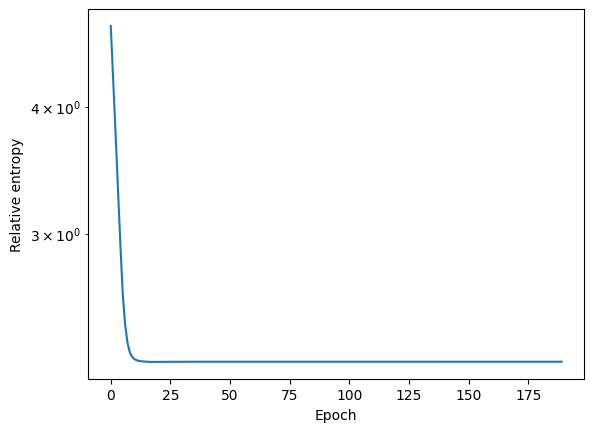

In [25]:
if compute_qre:
    plt.plot(qre_hist[1:], "-")
    plt.xlabel("Epoch")
    plt.ylabel("Relative entropy")
    plt.yscale("log")
    plt.show()

We already see a much larger relative entropy.

In [24]:
fidelity(target_eta, qbm_state.get_density_matrix())

0.4705952756663144

And a bad fidelity, because we are missing all the off-diagonal terms in the Hamiltonian of the model.